# 25/12/03 FANS count data Modelling and inference
In the previous notebook, I made a variety of exploratory plots to get a sense of which predictor variables may correlate with the nuclei counts. Both technical predictors, such as `sample_mass_mg`, `date_nuc_prep` and `incubation_time_hrs`, are included, as well as the three biological predictors of interest- `dpi`, `inoculum`, and `population`. 

In this notebook we will build a model for this data, and use its predctions as input to formal statistical tests.
## Section 1: Formal model selection
Here, I show formally that the negative binomial model is a better fit for my data than the Poisson. This is expected given the nature of the dataset, and going through these steps is probably overkill. A key difference between them is that the NB model accounts for overdispersion, whereas the Pois model assumes the variance and mean are approximately equal
1. First, by calculating the variance: mean ratio
2. Via a dispersion test after fitting an intercept-only Poisson model, we are assessing whether the observed variability in our data is compatible with a Poisson distribution whose mean equals the sample mean.
3. Fitting both an NB and a Poisson model and comparing AIC.


In [42]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from marginaleffects import *
from plotnine import *
from plotnine import scales
from marginaleffects import *
from mizani.formatters import comma_format

In [43]:
# load in the tidied, long-format FANS data

# base_path = Path("/home/tmurphy/phd_work/experiment_383/exp_383_flowCytometry_analysis")
# df_path = Path(base_path / "tidied_FANS_data/exp383_tidy_FANS_data_long.csv")
df = pd.read_csv("../tidied_FANS_data/exp383_tidy_FANS_data_long.csv")

# We only want the raw count data for this analysis.
df_raw = df[df['count_statistic']=='EstTotalCount'].copy()
# remind ourselves of the data
df_raw


,animal_id,group_no,inoculum,inoculation_batch,dpi,sample_mass_mg,date_nuc_prep,incubation_time_hrs,population,count_statistic,count_value
0,918310,1,RML,BATCH4,60,246,2025-05-06,19.00,NeuN+,EstTotalCount,4359464.0
1,917423,19,22L,BATCH3,120,207,2025-05-06,19.67,NeuN+,EstTotalCount,2913658.0
2,918309,4,CBH,BATCH4,60,240,2025-05-07,16.92,NeuN+,EstTotalCount,5017422.0
3,916462,1,RML,BATCH1,60,248,2025-05-08,18.50,NeuN+,EstTotalCount,4324274.0
4,918277,9,RML,BATCH4,90,220,2025-05-08,18.98,NeuN+,EstTotalCount,5102254.0
...,...,...,...,...,...,...,...,...,...,...,...
283,918318,4,CBH,BATCH4,60,221,2025-08-19,19.48,SOX2+,EstTotalCount,152305.0
284,917440,4,CBH,BATCH3,60,254,2025-08-20,18.80,SOX2+,EstTotalCount,261952.0
285,916468,19,22L,BATCH1,120,243,2025-08-20,19.43,SOX2+,EstTotalCount,171849.0
286,917445,3,22L,BATCH3,60,294,2025-08-21,22.62,SOX2+,EstTotalCount,358748.0


In [44]:
# specify an order to the factors columns
dpi_order = [60, 90, 120]
inoc_order = ['CBH', 'RML', 'ME7', '22L']
pop_order = ['NeuN+', 'PU1+', 'SOX10+', 'SOX2+']

# encode necessary cols as ordered categorical variables
df_raw['dpi'] = pd.Categorical(df_raw['dpi'], categories = dpi_order, ordered=True )
df_raw['inoculum'] = pd.Categorical(df_raw['inoculum'], categories = inoc_order, ordered=True )
df_raw['population'] = pd.Categorical(df_raw['population'], categories = pop_order, ordered=True )

In [45]:
# Assess the ratio of the variance to the mean
df_meanVar = (
    df_raw.groupby(['dpi', 'inoculum', 'population'])
    .agg(
        mean=('count_value', 'mean'),
        variance=('count_value', 'var')
    )
)
df_meanVar['var/mean'] = df_meanVar['variance'] / df_meanVar['mean']
df_meanVar.head() # variance >> mean

/tmp/ipykernel_9372/3503527557.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


mean      variance       var/mean
dpi inoculum population                                           
60  CBH      NeuN+       4.468945e+06  1.469023e+12  328717.978484
             PU1+        1.737722e+05  4.281052e+09   24636.007052
             SOX10+      6.228223e+05  1.013225e+10   16268.282582
             SOX2+       2.111372e+05  2.115732e+09   10020.651926
    RML      NeuN+       4.144304e+06  3.669277e+11   88537.832342

In [46]:
# Formal test of Poisson goodness of fit
# Fit minimal Poisson model (intercept only for raw dispersion test)

# Fit a minimal Poisson model with only an intercept term
m_pois = smf.glm(
    "count_value ~ 1",
    data=df_raw,
    family=sm.families.Poisson()
).fit()

resid_deviance = m_pois.deviance
resid_df       = m_pois.df_resid
dispersion     = resid_deviance / resid_df

print("Residual deviance:", resid_deviance)
print("Residual df:", resid_df)
print("Dispersion:", dispersion)

Residual deviance: 611148138.3893344
Residual df: 287
Dispersion: 2129436.0222624894


In [47]:
# Compare Poisson and NB models

# NB model with intercept only (no predictors)
m_nb_basic = smf.glm(
    "count_value ~ 1",
    data=df_raw,
    family=sm.families.NegativeBinomial()
).fit()

# Poisson model with biological predictors
m_pois_biol = smf.glm(
    "count_value ~ dpi * inoculum * population",
    data=df_raw,
    family=sm.families.Poisson()
).fit()

# NB model with biological predictors
m_nb_biol = smf.glm(
    "count_value ~ dpi * inoculum * population",
    data=df_raw,
    family=sm.families.NegativeBinomial()
).fit()

# Insepct AICs
print("Poisson (Intercept only) AIC:", m_pois.aic)
print("Poisson (+Predictors) AIC:", m_pois_biol.aic)
print("NB AIC:     ", m_nb_basic.aic)
print("NB (+Predictors):", m_nb_biol.aic)

/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


Poisson (Intercept only) AIC: 611152541.0597963
Poisson (+Predictors) AIC: 23752449.788695913
NB AIC:      8792.233545914758
NB (+Predictors): 8433.733215116896


## Section 2: Which technical covariates have explanatory power?
We next build several GLMs which include progressively more of the technical covariates recorded during the experimental process.
AIC values used to inform whether the inclusion of the predictor in question, or interactions between them, produces any relevant benedit.
Examination of the coefficients and p-values provides us with

In [48]:
# Building the NB model upwards from technical predictor variables

# Start with a model that only includes mass and an offset (scaling-factor)
# We expect that counts
m_nb_0 = smf.glm(
    "count_value ~ 1",
    data=df_raw,
    family=sm.families.NegativeBinomial(),
    offset=np.log(df_raw['sample_mass_mg'])
).fit()

m_nb_0.summary2()

/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            8790.2847 
Link Function:      Log              BIC:            -1155.7092
Dependent Variable: count_value      Log-Likelihood: -4394.1   
Date:               2025-12-30 01:30 LL-Null:        -4394.1   
No. Observations:   288              Deviance:       469.56    
Df Model:           0                Pearson chi2:   464.      
Df Residuals:       287              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|   [0.025  0.975]
----------------------------------------------------------------
Intercept     8.7956    0.0589  149.2670  0.0000  8.6802  8.9111
===============================================================

"""

In [49]:
# Add incubation time as a linear predictor
m_nb_1 = smf.glm(
    "count_value ~ incubation_time_hrs",
    data=df_raw,
    family=sm.families.NegativeBinomial(),
    offset=np.log(df_raw['sample_mass_mg'])    
).fit()

m_nb_1.summary2()

/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:                GLM               AIC:             8792.2543 
Link Function:        Log               BIC:             -1150.0766
Dependent Variable:   count_value       Log-Likelihood:  -4394.1   
Date:                 2025-12-30 01:30  LL-Null:         -4394.1   
No. Observations:     288               Deviance:        469.53    
Df Model:             1                 Pearson chi2:    464.      
Df Residuals:         286               Scale:           1.0000    
Method:               IRLS                                         
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept            8.9877   1.1266  7.9779 0.0000  6.7796 11.1957
incubation_time_hrs -0.0103   0.0605 -0.1707 0.8644 -0.1289  0.1082
===================================================================

"""

In [50]:
# Incubation time may only matter for certain populations
# of nuclei
# Build a model with an interation term
m_nb_2 = smf.glm(
    "count_value ~ incubation_time_hrs * population",
    data=df_raw,
    family=sm.families.NegativeBinomial(),
    offset=np.log(df_raw["sample_mass_mg"])
).fit()

m_nb_2.summary2()

/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Generalized linear model
========================================================================================
Model:                       GLM                      AIC:                    8360.9157 
Link Function:               Log                      BIC:                    -1559.4375
Dependent Variable:          count_value              Log-Likelihood:         -4172.5   
Date:                        2025-12-30 01:30         LL-Null:                -4394.1   
No. Observations:            288                      Deviance:               26.191    
Df Model:                    7                        Pearson chi2:           26.1      
Df Residuals:                280                      Scale:                  1.0000    
Method:                      IRLS                                                       
----------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------
Intercept                                10.0078   2.2531  4.4417 0.0000  5.5917 14.4238
population[T.PU1+]                       -2.2578   3.1864 -0.7086 0.4786 -8.5030  3.9875
population[T.SOX10+]                     -1.2644   3.1864 -0.3968 0.6915 -7.5096  4.9808
population[T.SOX2+]                      -2.3917   3.1864 -0.7506 0.4529 -8.6369  3.8536
incubation_time_hrs                      -0.0047   0.1210 -0.0388 0.9690 -0.2418  0.2324
incubation_time_hrs:population[T.PU1+]   -0.0422   0.1711 -0.2467 0.8051 -0.3775  0.2931
incubation_time_hrs:population[T.SOX10+] -0.0195   0.1711 -0.1141 0.9092 -0.3548  0.3158
incubation_time_hrs:population[T.SOX2+]  -0.0278   0.1711 -0.1622 0.8711 -0.3631  0.3075
========================================================================================

"""

In [51]:
# See if there is a date effect on nuclei count, e.g. protocol competency increased with time

# Recode the date_nuc_prep as an ordinal time variable
# Avoids treating datetime as a categorical variable with loads of levels.

# 1. To datetime
df_raw["date_nuc_prep"] = pd.to_datetime(df_raw["date_nuc_prep"])

# 2. datetime --> ordinal (as new col)
df_raw['date_ord'] = df_raw['date_nuc_prep'].dt.date.apply(lambda d: d.toordinal())

# Fit the model (date of prep as ordinal)
m_nb_date = smf.glm(
    "count_value ~ date_ord",
    data=df_raw,
    family=sm.families.NegativeBinomial(),
    offset=np.log(df_raw["sample_mass_mg"])
).fit()

m_nb_date.summary2()

/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
================================================================
Model:               GLM              AIC:            8788.6309 
Link Function:       Log              BIC:            -1153.7001
Dependent Variable:  count_value      Log-Likelihood: -4392.3   
Date:                2025-12-30 01:30 LL-Null:        -4394.1   
No. Observations:    288              Deviance:       465.91    
Df Model:            1                Pearson chi2:   456.      
Df Residuals:        286              Scale:          1.0000    
Method:              IRLS                                       
----------------------------------------------------------------
            Coef.     Std.Err.    z    P>|z|    [0.025    0.975]
----------------------------------------------------------------
Intercept -2585.4508 1314.9781 -1.9662 0.0493 -5162.7605 -8.1412
date_ord      0.0035    0.0018  1.9728 0.0485     0.0000  0.0070
================================================================

"""

In [52]:
# Model that factors into account an interaction between
# the date of the prep and the population
# Rational: upward trend in nuclei yield as time went on, when the antibodies 
# were not problematic  (i.e. NeuN), but there is no obvious link between date and yield
# for populations where antibody issues occurred
m_nb_dateXpop = smf.glm(
    "count_value ~ date_ord * population",
    data=df_raw,
    family=sm.families.NegativeBinomial(),
    offset=np.log(df_raw['sample_mass_mg'])
).fit()

m_nb_dateXpop.summary2()

/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Generalized linear model
======================================================================================
Model:                       GLM                     AIC:                   8358.0575 
Link Function:               Log                     BIC:                   -1562.2957
Dependent Variable:          count_value             Log-Likelihood:        -4171.0   
Date:                        2025-12-30 01:30        LL-Null:               -4394.1   
No. Observations:            288                     Deviance:              23.333    
Df Model:                    7                       Pearson chi2:          23.8      
Df Residuals:                280                     Scale:                 1.0000    
Method:                      IRLS                                                     
--------------------------------------------------------------------------------------
                                Coef.     Std.Err.    z    P>|z|    [0.025     0.975] 
--------------------------------------------------------------------------------------
Intercept                     -2636.3199 2629.9529 -1.0024 0.3161 -7790.9328 2518.2931
population[T.PU1+]             -164.6035 3719.3226 -0.0443 0.9647 -7454.3418 7125.1348
population[T.SOX10+]             17.4112 3719.3196  0.0047 0.9963 -7272.3213 7307.1437
population[T.SOX2+]            1372.9620 3719.3221  0.3691 0.7120 -5916.7754 8662.6994
date_ord                          0.0036    0.0036  1.0062 0.3143    -0.0034    0.0105
date_ord:population[T.PU1+]       0.0002    0.0050  0.0434 0.9654    -0.0096    0.0101
date_ord:population[T.SOX10+]    -0.0000    0.0050 -0.0051 0.9959    -0.0099    0.0098
date_ord:population[T.SOX2+]     -0.0019    0.0050 -0.3699 0.7114    -0.0117    0.0080
======================================================================================

"""

In [53]:
# Take a look at the AIC values for the technical predictor models we made
df_aic = pd.DataFrame(
    {
        'model': ["Mass_offset_model", "Incubation_model", "Incubation*pop_model", "PrepDate_model", "Date*pop_model"],
        'AIC': [m_nb_0.aic, m_nb_1.aic, m_nb_2.aic, m_nb_date.aic, m_nb_dateXpop.aic]
    }
).sort_values(by='AIC').reset_index(drop=True)

df_aic # Date*pop_model and incubation*pop_model are very close. 

,model,AIC
0,Date*pop_model,8358.057523
1,Incubation*pop_model,8360.915704
2,PrepDate_model,8788.630882
3,Mass_offset_model,8790.284709
4,Incubation_model,8792.254299


In [54]:
# fit another glm that examines the interactions between incubation,
# date and population.

m_nb_datePopIncub = smf.glm(
    "count_value ~  incubation_time_hrs * population + date_ord * population",
    data=df_raw,
    family=sm.families.NegativeBinomial(),
    offset=np.log(df_raw['sample_mass_mg'])
).fit()

m_nb_datePopIncub.summary2() # The combination of incubation_time* date & population*date produces a higher AIC than either alone

/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Generalized linear model
=================================================================================================
Model:                          GLM                         AIC:                       8365.6854 
Link Function:                  Log                         BIC:                       -1540.0159
Dependent Variable:             count_value                 Log-Likelihood:            -4170.8   
Date:                           2025-12-30 01:30            LL-Null:                   -4394.1   
No. Observations:               288                         Deviance:                  22.961    
Df Model:                       11                          Pearson chi2:              23.4      
Df Residuals:                   276                         Scale:                     1.0000    
Method:                         IRLS                                                             
-------------------------------------------------------------------------------------------------
                                           Coef.     Std.Err.    z    P>|z|    [0.025     0.975] 
-------------------------------------------------------------------------------------------------
Intercept                                -2668.8974 2646.7485 -1.0084 0.3133 -7856.4291 2518.6344
population[T.PU1+]                        -134.0520 3743.0730 -0.0358 0.9714 -7470.3403 7202.2364
population[T.SOX10+]                       -24.4698 3743.0700 -0.0065 0.9948 -7360.7523 7311.8127
population[T.SOX2+]                       1307.7063 3743.0726  0.3494 0.7268 -6028.5812 8643.9937
incubation_time_hrs                         -0.0162    0.1218 -0.1332 0.8940    -0.2548    0.2224
incubation_time_hrs:population[T.PU1+]      -0.0334    0.1722 -0.1941 0.8461    -0.3709    0.3041
incubation_time_hrs:population[T.SOX10+]    -0.0199    0.1722 -0.1153 0.9082    -0.3573    0.3176
incubation_time_hrs:population[T.SOX2+]     -0.0232    0.1722 -0.1346 0.8929    -0.3606    0.3143
date_ord                                     0.0036    0.0036  1.0121 0.3115    -0.0034    0.0106
date_ord:population[T.PU1+]                  0.0002    0.0051  0.0352 0.9719    -0.0097    0.0101
date_ord:population[T.SOX10+]                0.0000    0.0051  0.0062 0.9951    -0.0099    0.0100
date_ord:population[T.SOX2+]                -0.0018    0.0051 -0.3500 0.7263    -0.0117    0.0082
=================================================================================================

"""

In [55]:
# Check for collinearity between incubation and date
prep_date_incubation_corr = (
    df_raw[['incubation_time_hrs', 'date_ord']].corr()
)
prep_date_incubation_corr # no real correlation between incubation time and date of prep

,incubation_time_hrs,date_ord
incubation_time_hrs,1.000000,0.113317
date_ord,0.113317,1.000000


In [56]:
# Check for collinearity between incubation and date
prep_date_incubation_corr = (
    df_raw.groupby('population')[['count_value', 'date_ord']].corr()
)
prep_date_incubation_corr

/tmp/ipykernel_9372/1003596087.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


count_value  date_ord
population                                   
NeuN+      count_value     1.000000  0.487414
           date_ord        0.487414  1.000000
PU1+       count_value     1.000000  0.330710
           date_ord        0.330710  1.000000
SOX10+     count_value     1.000000  0.408281
           date_ord        0.408281  1.000000
SOX2+      count_value     1.000000  0.173158
           date_ord        0.173158  1.000000

## Section 3: Fitting the model
From section 2, I have decided to include only `incubation_time*population` as the technical explanotry varaibles.
When fitting a GLM with negative binomial dispersion assumptions, the alpha (dispersion) value is not calculated but user-supplied.
We can fit a true negative binomial model using MLE, which will provide us with an estimation for alpha.
We can then pass the estimated alpha value to the GLM. 

In [57]:
# Specify the full model formula

full_formula = ''' 
count_value ~ dpi * inoculum * population + incubation_time_hrs * population
'''
part_formula = '''
count_value ~ dpi * inoculum * population
'''

In [58]:
#  Build a design matrix for the full model 
y_full, x_full = patsy.dmatrices(full_formula, data=df_raw, return_type="dataframe")

# design matrix for the model with no technical predictors
y_part, x_part = patsy.dmatrices(part_formula, data=df_raw, return_type="dataframe")

# Specify the offset term
offset = np.log(df_raw['sample_mass_mg'])

# x_full # design matrix of explanatory variables of interest (y_full is count values for all samples)

In [59]:
# Fit the full negative binomial model 
nb_full = sm.NegativeBinomial(
    endog=y_full,
    exog=x_full,
    offset=offset,
    loglike_method='nb2'
).fit()

#nb_full.summary2() # optimiser did not converge on values for all coefficients, but alpha estimation looks good
alpha = nb_full.params.alpha

         Current function value: 13.485509
         Iterations: 35
         Function evaluations: 45
         Gradient evaluations: 45


/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/scipy/optimize/_optimize.py:1330: OptimizeWarning: Maximum number of iterations has been exceeded.
/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


### Section 4: Model-based predictions
Generate model-based expected counts for each population, dpi, and inoculum combination using the fitted NB GLM.
Predictions are anchored to the median observed sample mass and incubation time to reflect a typical experiment.

In [60]:
# Calculate reference values for the offset and technical covariate
median_mass = df_raw['sample_mass_mg'].median()
median_incubation = df_raw['incubation_time_hrs'].median()

median_mass, median_incubation

(np.float64(239.0), np.float64(18.71))

In [61]:
# Build a prediction grid for every population, dpi, and inoculum combination
pop_levels = df_raw['population'].cat.categories
dpi_levels = df_raw['dpi'].cat.categories
inoc_levels = df_raw['inoculum'].cat.categories

prediction_grid = pd.MultiIndex.from_product(
    [pop_levels, dpi_levels, inoc_levels],
    names=['population', 'dpi', 'inoculum']
).to_frame(index=False)

# retain the ordered categoricals so the design matrix matches the model
prediction_grid['population'] = pd.Categorical(prediction_grid['population'], categories=pop_levels, ordered=True)
prediction_grid['dpi'] = pd.Categorical(prediction_grid['dpi'], categories=dpi_levels, ordered=True)
prediction_grid['inoculum'] = pd.Categorical(prediction_grid['inoculum'], categories=inoc_levels, ordered=True)

prediction_grid['incubation_time_hrs'] = median_incubation
prediction_grid['sample_mass_mg'] = median_mass

pred_offset = np.log(prediction_grid['sample_mass_mg'])

# Build a design matrix that matches the model fit
x_pred = patsy.build_design_matrices([x_full.design_info], prediction_grid)[0]

pred_res = nb_full.get_prediction(x_pred, offset=pred_offset)
pred_frame = pred_res.summary_frame()

prediction_grid = pd.concat(
    [prediction_grid, pred_frame[['predicted', 'ci_lower', 'ci_upper']]], axis=1
)
prediction_grid = prediction_grid.rename(
    columns={'predicted': 'expected_count'}
)
prediction_grid.head()


/home/tjm_p/miniforge3/envs/fans-analysis/lib/python3.13/site-packages/statsmodels/base/_prediction_inference.py:782: UserWarning: using default log-link in get_prediction


,population,dpi,inoculum,incubation_time_hrs,sample_mass_mg,expected_count,ci_lower,ci_upper
0,NeuN+,60,CBH,18.71,239.0,4.781747e+06,3.905009e+06,5.855327e+06
1,NeuN+,60,RML,18.71,239.0,4.253170e+06,3.481543e+06,5.195814e+06
2,NeuN+,60,ME7,18.71,239.0,4.799021e+06,3.927926e+06,5.863297e+06
3,NeuN+,60,22L,18.71,239.0,5.167521e+06,4.185629e+06,6.379751e+06
4,NeuN+,90,CBH,18.71,239.0,4.757478e+06,3.885793e+06,5.824705e+06


/tmp/ipykernel_9372/173090132.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


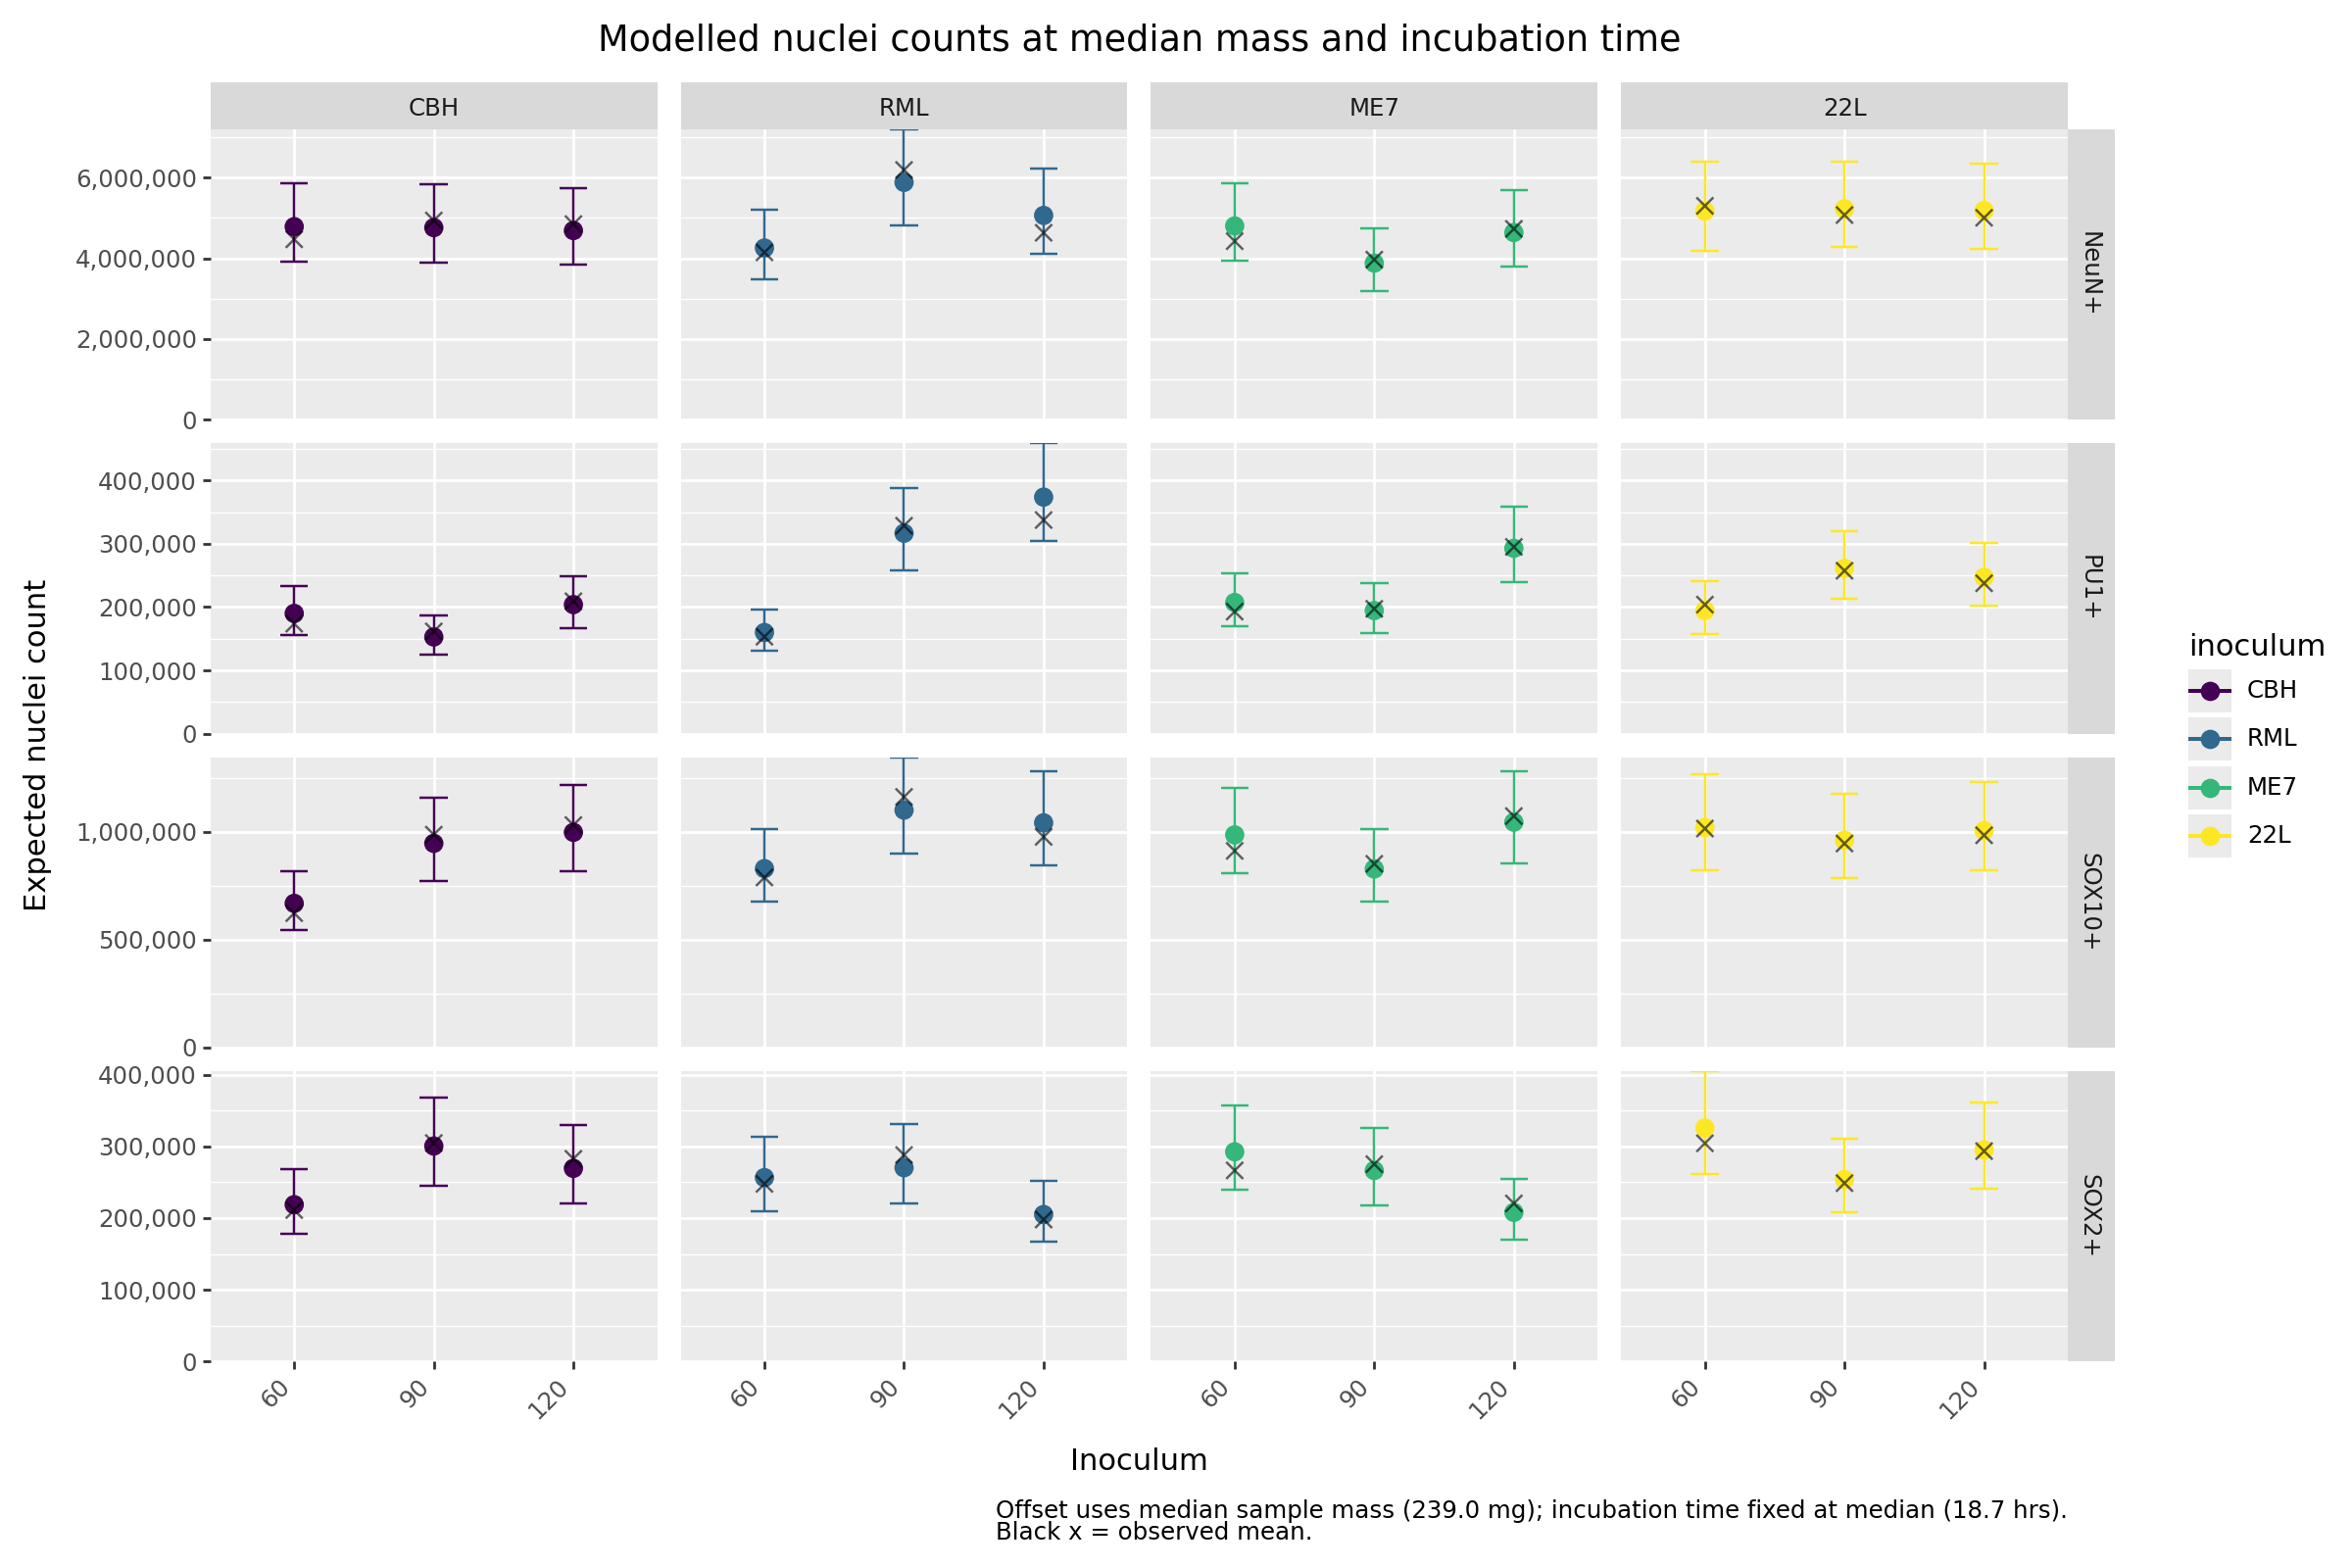

In [68]:
# Plot modelled counts with 95% confidence intervals and overlay observed means
observed_summary = (
    df_raw.groupby(['population', 'dpi', 'inoculum'])
    .agg(observed_median=('count_value', 'median'), observed_mean=('count_value', 'mean'))
    .reset_index()
)

plot_df = prediction_grid.merge(observed_summary, on=['population', 'dpi', 'inoculum'], how='left')
caption_text = (
    f"Offset uses median sample mass ({median_mass:.1f} mg); "
    f"incubation time fixed at median ({median_incubation:.1f} hrs).\n"
    "Black x = observed mean."
)

(
    ggplot(plot_df, aes(x='dpi', y='expected_count', color='inoculum'))
    + geom_point(position=position_dodge(width=0.6), size=3)
    + geom_errorbar(aes(ymin='ci_lower', ymax='ci_upper'), width=0.2, position=position_dodge(width=0.6))
    + geom_point(aes(y='observed_mean'), shape='x', color='black', size=3, position=position_dodge(width=0.6), alpha=0.6)
    + facet_grid('population~inoculum', scales='free_y')
    + scale_y_continuous(labels=comma_format(), expand=(0, 0))
    + expand_limits(y=0)
    + labs(
        title='Modelled nuclei counts at median mass and incubation time',
        y='Expected nuclei count',
        x='Inoculum',
        caption=caption_text,
    )
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(12, 8))
)
